In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [1]:
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)
import tensorflow as tf

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

In [ ]:
tf.config.set_visible_devices([], 'GPU')

In [10]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [4]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0).astype("str")
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(r"C:\Users\Tejas\Desktop\Capstone\hate-speech-project\glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [5]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(Bidirectional(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.2)))
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [6]:
def experiment(train_df, test_df):
  print("Running Experiment ... ")
  X_train = train_df.Text
  y_train = train_df.label.astype(np.float32)

  X_test = test_df.Text
  y_test = test_df.label.astype(np.float32)
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  print("Generating Glove ...")
  X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
  with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=5,
                              batch_size=1024,
                              verbose=1,steps_per_epoch=10)
    warnings.simplefilter("ignore")
  print("\n Plotting results ... \n")
  plot_graphs(history, 'accuracy')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_RNN.predict(X_test_Glove)
  #print(predicted)
  print("YTEST")
  print(y_test[-20:-10])
  print("PREDICTED")
  
  print(predicted[-20:-10])
  binary_predictions = []

  for val in predicted:
    if val[0] >= 0.5:
      binary_predictions.append(0.0)
    elif val[0] < 0.5:
      binary_predictions.append(1.0)

  print(metrics.classification_report(y_test, binary_predictions))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, binary_predictions)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))

In [7]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

In [11]:
train = pd.read_csv(r'C:\Users\Tejas\Desktop\Capstone\DatasetsCleaned\UniformClasses\V2\train\ohc_train.csv', sep='\t')

In [12]:
train

,Text,Class
0,\tif want big buck tri moba,NOT
1,\t\t\tthe democrat republican polit flip old ...,NOT
2,\ta year back twat protest japanes cultur exh...,NOT
3,\t\tbut give cheater money cuz vagina fine le...,NOT
4,\thow reboot franchis less content origin gam...,NOT
...,...,...
8280,\t\tare still peopl pretend trump isnt retard...,NOT
8281,\t\t\t\t\tjust look ugli butch dyke look one,NOT
8282,\t\tyeah saw one later bitter bitter human,NOT
8283,\t\t\t\tnope call finotci us one capitalist ...,NOT


In [13]:
train['label'] = ''

for row in range(len(train)):
    if train['Class'][row] == "OFF":
        train.at[row, 'label'] = 1
    else:
        train.at[row, 'label'] = 0

In [14]:
train

,Text,Class,label
0,\tif want big buck tri moba,NOT,0
1,\t\t\tthe democrat republican polit flip old ...,NOT,0
2,\ta year back twat protest japanes cultur exh...,NOT,0
3,\t\tbut give cheater money cuz vagina fine le...,NOT,0
4,\thow reboot franchis less content origin gam...,NOT,0
...,...,...,...
8280,\t\tare still peopl pretend trump isnt retard...,NOT,0
8281,\t\t\t\t\tjust look ugli butch dyke look one,NOT,0
8282,\t\tyeah saw one later bitter bitter human,NOT,0
8283,\t\t\t\tnope call finotci us one capitalist ...,NOT,0


In [15]:
test = pd.read_csv(r'C:\Users\Tejas\Desktop\Capstone\DatasetsCleaned\UniformClasses\V2\test\ohc_test.csv', sep='\t')

In [16]:
test['label'] = ''

for row in range(len(test)):
    if test['Class'][row] == "OFF":
        test.at[row, 'label'] = 1
    else:
        test.at[row, 'label'] = 0

In [17]:
test

,Text,Class,label
0,retard \ti havent seen \t\ti think meant co...,OFF,1
1,\t\t\texact im think joke,NOT,0
2,\twhi alway seem like mother thing rare hear ...,NOT,0
3,twat pos still postit,NOT,0
4,mean realli abl drive \tyea see stabl job ab...,OFF,1
...,...,...,...
2085,\t\t\t\t\t\t\t\twell beto smuggest asshol ive...,NOT,0
2086,entertain thought sex bot appeal rape fantans...,NOT,0
2087,fuckin cunt,OFF,1
2088,\trpunchablefac edit aww someon alreadi post,NOT,0


In [18]:
train_df = shuffle(train)
test_df = shuffle(test)

Running Experiment ... 
Generating Glove ...
Found 22321 unique tokens.
(10375, 500)
Total 400000 word vectors.
Building Model ...
32
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           1116100   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 64)           21248     
_________________________________________________________________
dropout (Dropout)            (None, 500, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 64)           24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 64)          

10/10 [==============================] - 3323s 272s/step - loss: 0.4726 - accuracy: 0.7933 - val_loss: 0.4458 - val_accuracy: 0.7995

 Plotting results ... 



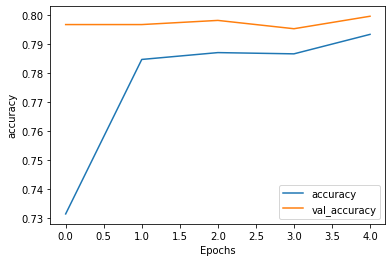

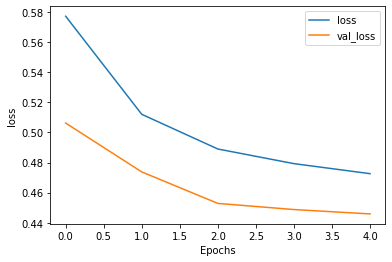


 Evaluating Model ... 

YTEST
1762    1.0
1651    0.0
19      0.0
1126    0.0
218     1.0
397     0.0
1213    0.0
767     0.0
95      1.0
1502    0.0
Name: label, dtype: float32
PREDICTED
[[0.8749901  0.12500986]
 [0.821328   0.17867199]
 [0.8774767  0.12252332]
 [0.8787523  0.12124766]
 [0.38291985 0.6170802 ]
 [0.73697156 0.2630284 ]
 [0.87858266 0.1214173 ]
 [0.8794316  0.12056834]
 [0.86220384 0.13779613]
 [0.87798303 0.12201694]]
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      1665
         1.0       0.51      0.33      0.40       425

    accuracy                           0.80      2090
   macro avg       0.68      0.62      0.64      2090
weighted avg       0.78      0.80      0.78      2090





INFO:logger:  mcc = 0.29568661421196485
INFO:logger:  tp = 139
INFO:logger:  tn = 1532
INFO:logger:  fp = 133
INFO:logger:  fn = 286
INFO:logger:  precision = 0.5110294117647058
INFO:logger:  recall = 0.3270588235294118
INFO:logger:  F1 = 0.39885222381635577
INFO:logger:  accuracy = 0.7995215311004785


In [19]:
experiment(train_df, test_df)